In [1]:
# 라이브러리 호출
import re 
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumMyeongjo')

In [2]:
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [3]:
data_path = './autoint/ml-1m'

In [4]:
# 데이터를 불러옵니다.
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

# 1. 데이터 users: user 정보
사용자 정보는 user_id, gender, age, occupation, zip 정보로 구성되어 있습니다.

* user_id: 1부터 6040으로, 익명의 정보로 되어 있음
* gender: M or F
* age: 18세 이하는 1, 18 ~ 24세는 18, 25 ~ 34는 25 등과 같이 구성되어 있음
* occupation: 2는 artist, 8은 farmer 등으로 숫자값으로 매핑되어 있음

In [5]:
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 2. 데이터 ratings: rating 정보
사용자의 평점이 담겨 있는 데이터입니다. 아래와 같이 데이터가 저장되어 있습니다.

* user_id, movie_id, rating, timestamp 컬럼으로 데이터 저장
* user_id: 1부터 6040으로, 익명의 정보로 되어 있음
* movie_id: 1부터 3952로, 익명의 정보로 되어 있음
* rating: 5점 평점
* timestamp: Unix timestamp로 되어 있음.


| Unix timestamp란

1970년 1월 1일 00:00:00 UTC 이후 경과한 '초' 수를 말합니다. 우리가 흔히 알고 있는 연-월-일로 변환이 필요합니다.

In [6]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 3. 데이터 movies: movie 정보
영화 정보가 담겨져 있는 데이터입니다. 아래와 같이 데이터가 저장되어 있습니다.

* movie_id title, genres 컬럼으로 데이터 저장
* movie_id : 1부터 3952로, 익명의 정보로 되어 있음
* title: 영화 제목과 연도가 함께 입력되어 있음
* genres: Action, Comedy 등의 장르가 입력되어 있음

In [7]:
print(movies.shape)
movies.head() # 마지막 MovieID를 확인하려면 head() 대신 tail()로 확인해 보세요.

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 데이터 분석

1. 장르별 영화 수
2. 연도별 영화 수
3. 평점 분포
4. 장르별 평점

### 1. 영화데이터(movies)
영화 데이터에는 영화 ID(movie_id), 영화 제목(title), 장르(genres)의 정보만 포함되어 있습니다. 하지만 이 데이터의 정보를 분리해서 연도별 분석, 장르별 분석이 가능하게 할 수 있습니다.

가장 먼저, 영화의 제목과 연도를 분리해 봅시다.

영화 제목을 보면 'Toy Story (1995)'와 같이 영화 제목과 연도가 같이 입력되어 있는데요. 영화 제목에서 연도만 뽑아내면 연도와 영화 제목으로 나눌 수 있겠죠?

정규표현식을 이용해서 영화 제목에서 연도를 뽑아냅시다.

In [8]:
# 이 정규표현식은 '괄호 안에 있는 숫자4개만 뽑아주세요.'라는 의미입니다. 
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [9]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


장르를 분리할 수도 있습니다.

현재 genres 컬럼은 'Animation|Children's|Comedy'처럼 |를 기준으로 여러 개의 장르가 한 데이터에 모두 들어가 있는 상태입니다. 즉 |를 기준으로 각 장르를 분리할 수 있다는 거죠!

이때 .split 함수를 이용합니다. 문자열에 split을 적용하게 되면 split(기준)으로 데이터가 나뉘어 리스트로 변환되는데요, 이를 dataframe의 explode 함수를 적용하면 쫙 펼칠 수 있습니다.

In [10]:
# 장르를 분리 - 소속 장르 별로 row가 생성 됨. 같은 영화가 중복되어 들어 가게 됨.
movies['genres_split'] = movies['genres'].apply(lambda x: x.split('|'))
movies_exploded = movies.explode('genres_split')
movies_exploded.head(10)

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Romance
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Drama


* 장르별 영화 개수
    * x축: 장르
    * y축: 개수

In [11]:
# plotly 버전(로컬 환경 또는 클라우드 노트북 환경에서 실행시켜 주세요!)
px.histogram(movies_exploded, x='genres_split', height=450, title='장르별 영화 수').update_xaxes(categoryorder="total descending")

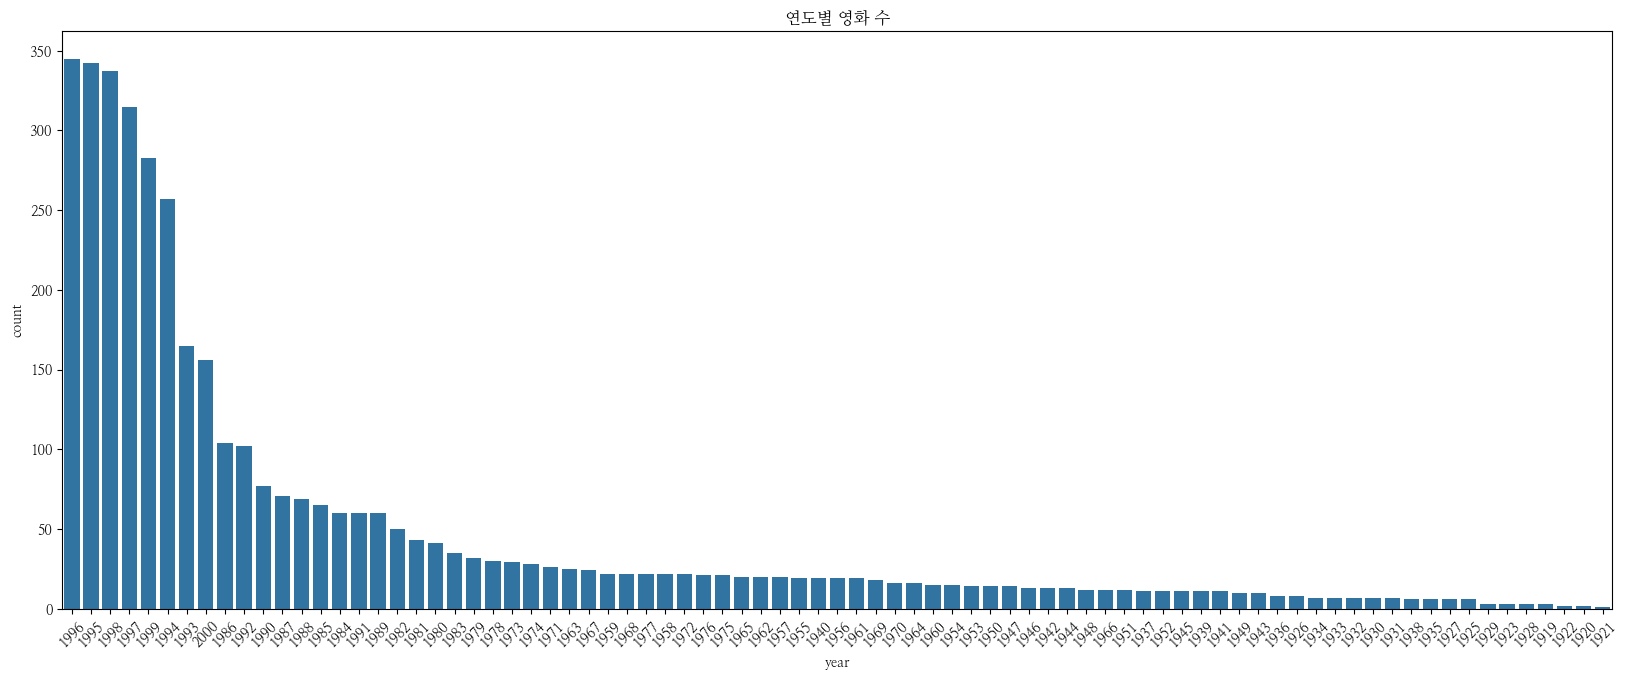

In [12]:
# seaborn 버전
year_counts = movies['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

year_counts = year_counts.sort_values('count', ascending=False)

sns.barplot(x='year', y='count', data=year_counts)

plt.gcf().set_size_inches(20, 7.5)
plt.title('연도별 영화 수')
plt.xticks(rotation=45)
plt.show()

### 2. 평점 데이터(ratings)
이제 평점 데이터로 영화를 분석해보겠습니다.
평점 데이터에서는 평균 평점이나 장르별 평점과 같이 다양한 관점으로 분석할 수 있습니다.

평균 평점과 장르별 평점을 살펴봅시다.

먼저, 평점 데이터에서 movie_id를 기준으로 평점을 평균냅시다. 이는 groupby를 이용하면 빠르게 구할 수 있습니다.

In [13]:
mv_rating_agg = pd.DataFrame(ratings.groupby('movie_id')['rating'].mean())
mv_rating_agg['num_of_ratings'] = pd.DataFrame(ratings.groupby('movie_id')['rating'].count())
mv_rating_agg = mv_rating_agg.reset_index()
mv_rating_agg.columns = ['movie_id', 'avg_rating', 'num_of_ratings']
mv_rating_agg

,movie_id,avg_rating,num_of_ratings
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


⭐ 평점 분포

평균 평점별 영화 수를 히스토그램으로 그려봅시다.

* x축: 평균 평점
* y축: 개수

In [15]:
# ⭐ 평점 분포 시각화
px.histogram(mv_rating_agg, x='avg_rating', height=450, title='평점 분포')

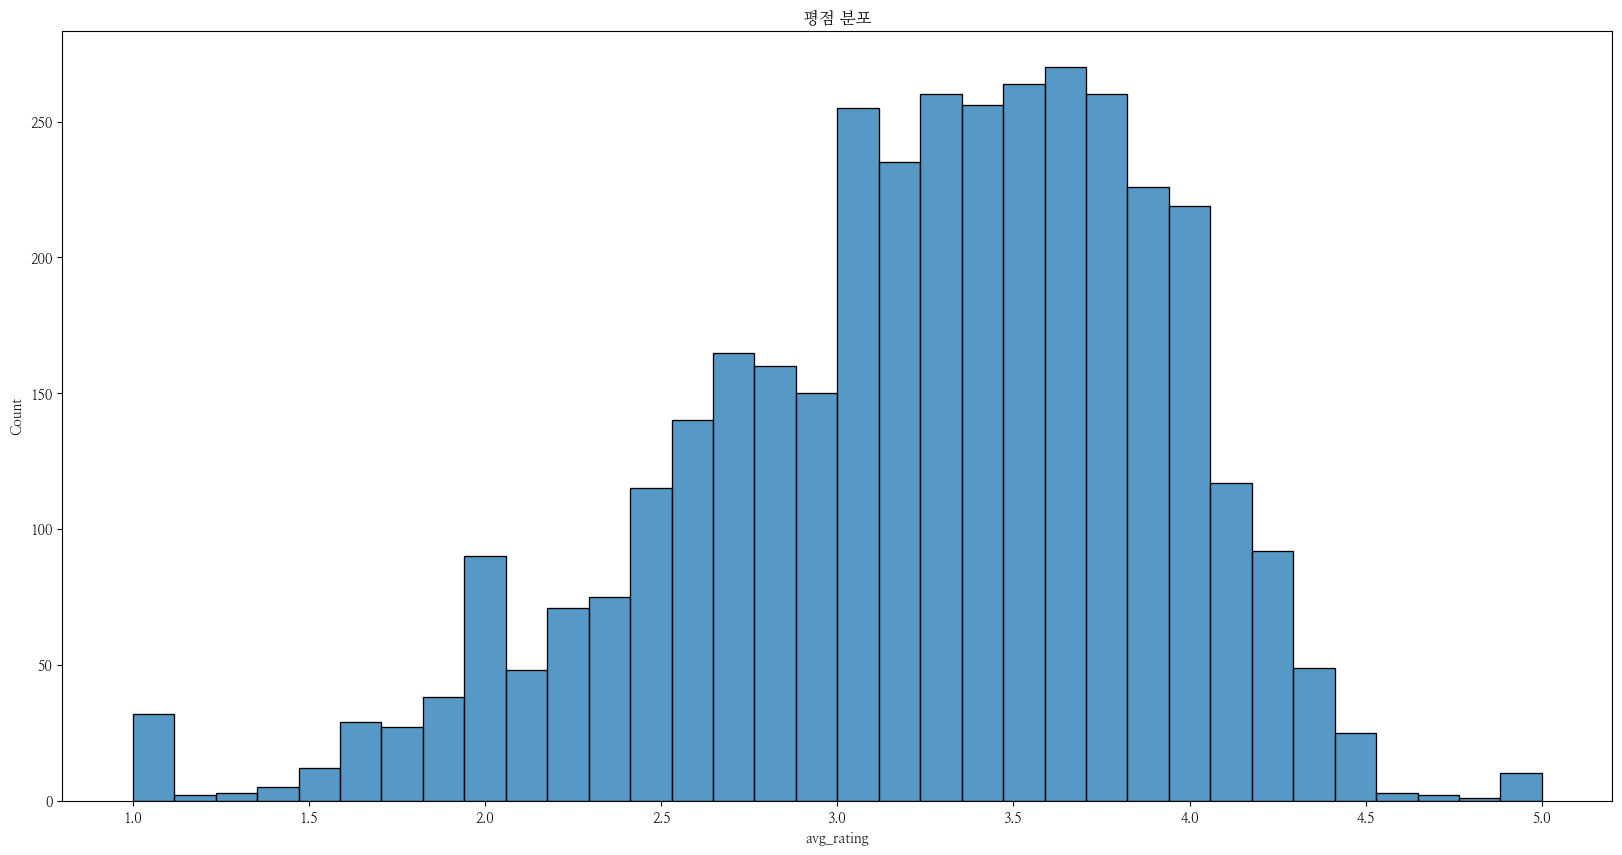

In [16]:
# seaborn 버전 
sns.histplot(mv_rating_agg['avg_rating'], kde=False)
plt.gcf().set_size_inches(20, 10)
plt.title('평점 분포')
plt.show()

정규분포의 형태는 나오지 않네요. 1점과 5점은 매우 적고 평점 3.5정도의 분포가 가장 많습니다.

# 3. 장르별 평점 분포
마지막으로 장르를 기준으로 평점 분석을 해보겠습니다.

위에서 우리는 장르를 genres_split으로 나누어 봤었는데요, 이 데이터를 활용해 장르 분포를 살펴볼 것입니다. 왜냐하면 하나의 영화에는 1개 이상의 장르가 연결되어 있기 때문입니다.

예를 들어 'Toy Story (1995)'는 3개(Animation, Children's, Comedy)의 장르를 가지고 있으니, 토이스토리 평점이 4점이라면 각 장르의 대한 점수도 4점이라고 가정하는 것이죠.

In [17]:
movies_exploded.head()

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's


장르별 평점 분포를 파악하기 위해 아래와 같은 순서로 데이터를 만들어 봅시다.

1. 영화 평점 데이터와 영화 데이터를 합쳐준다.
2. genre_split를 기준으로 groupby한다.
3. groupby할 때 rating을 기준으로 평균(mean)과 개수(count)를 뽑아낸다.
4. rating과 mean을 기준으로 정렬한다.

In [18]:
rating_by_genre_df = pd.merge(ratings[['movie_id', 'rating']] ,movies_exploded[['movie_id', 'genres_split']] ,on='movie_id').groupby('genres_split').agg({'rating': ['mean', 'count']}).sort_values(('rating', 'mean')).reset_index()
rating_by_genre_df

genres_split    rating        
                     mean   count
0        Horror  3.215013   76386
1    Children's  3.422035   72186
2       Fantasy  3.447371   36301
3        Sci-Fi  3.466521  157294
4     Adventure  3.477257  133953
5        Action  3.491185  257457
6        Comedy  3.522099  356580
7      Thriller  3.570466  189680
8       Romance  3.607465  147523
9       Western  3.637770   20683
10      Musical  3.665519   41533
11      Mystery  3.668102   40178
12    Animation  3.684868   43293
13        Crime  3.708679   79541
14        Drama  3.766332  354529
15          War  3.893327   68527
16  Documentary  3.933123    7910
17    Film-Noir  4.075188   18261

In [19]:
rating_by_genre_df.columns

MultiIndex([('genres_split',      ''),
            (      'rating',  'mean'),
            (      'rating', 'count')],
           )

In [20]:
# 컬럼 한줄로 변경 : 위 과정은 col[0]의 값이 rating이면 _ 를 기준으로 데이터를 묶어달라는 의미
for col in rating_by_genre_df.columns.values:
    if col[0] == 'rating':
        print('_'.join(col).strip())
    else:
        print(col[0])

genres_split
rating_mean
rating_count


In [21]:
rating_by_genre_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in rating_by_genre_df.columns.values]    
rating_by_genre_df

,genres_split,rating_mean,rating_count
0,Horror,3.215013,76386
1,Children's,3.422035,72186
2,Fantasy,3.447371,36301
3,Sci-Fi,3.466521,157294
4,Adventure,3.477257,133953
5,Action,3.491185,257457
6,Comedy,3.522099,356580
7,Thriller,3.570466,189680
8,Romance,3.607465,147523
9,Western,3.637770,20683


장르 별 평점이기 때문에 바(bar) 차트를 활용해 볼겁니다.

* x축: 장르
* y축: 평균 평점

위와 같이 x축과 y축을 설정해서 바 차트를 만들어 봅시다.

In [22]:
px.bar(rating_by_genre_df, x='genres_split', y='rating_mean', height=350, title='장르별 평점').update_xaxes(categoryorder="total descending")

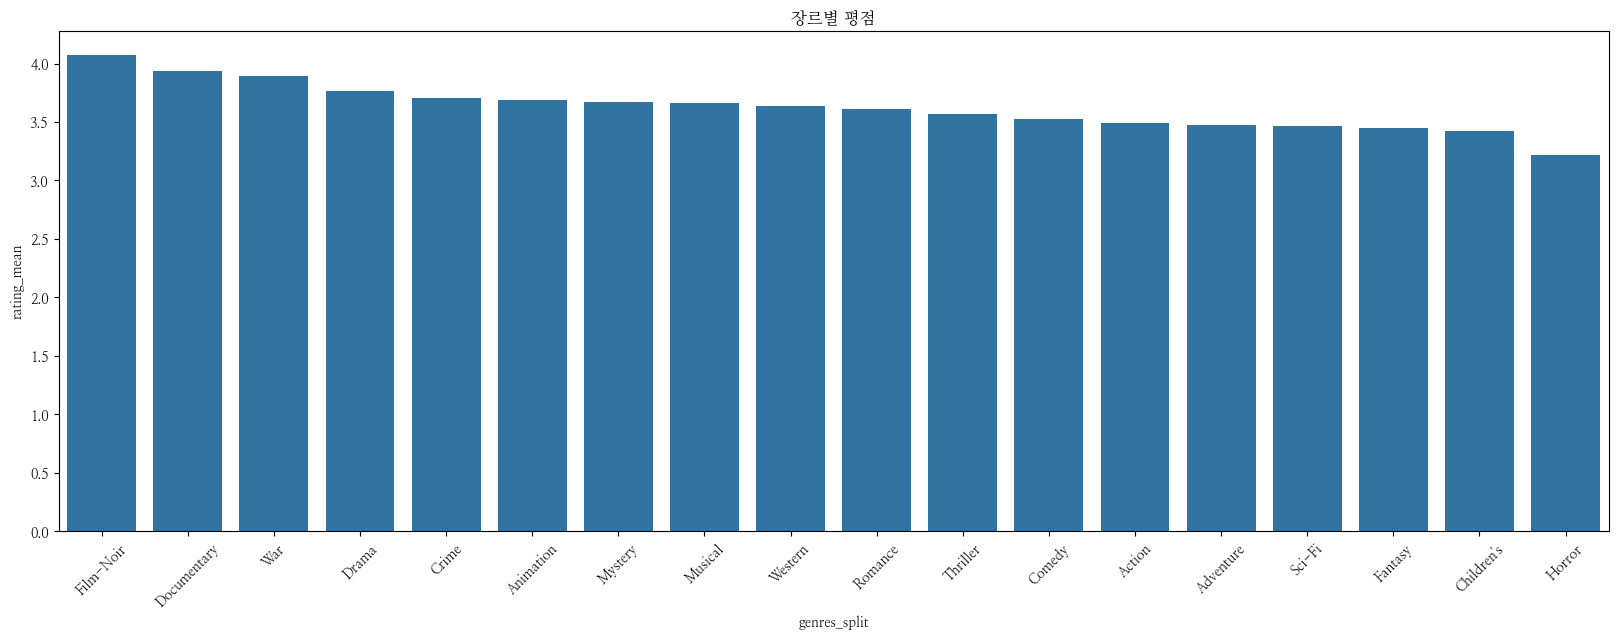

In [23]:
# seaborn 버전
rating_by_genre_df_sorted_by_mean = rating_by_genre_df.sort_values('rating_mean', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_mean', data=rating_by_genre_df_sorted_by_mean)
plt.title('장르별 평점')
plt.xticks(rotation=45)
plt.show()

큐멘터리 평점이 신뢰할 수 있는 값일까요?

좀 더 살펴보기 위해 장르별로 평가 개수를 확인해 봅시다.

* x축: 장르
* y축: 평가 개수

In [24]:
px.bar(rating_by_genre_df, x='genres_split', y='rating_count', height=350, title='장르별 평가 개수').update_xaxes(categoryorder="total descending")

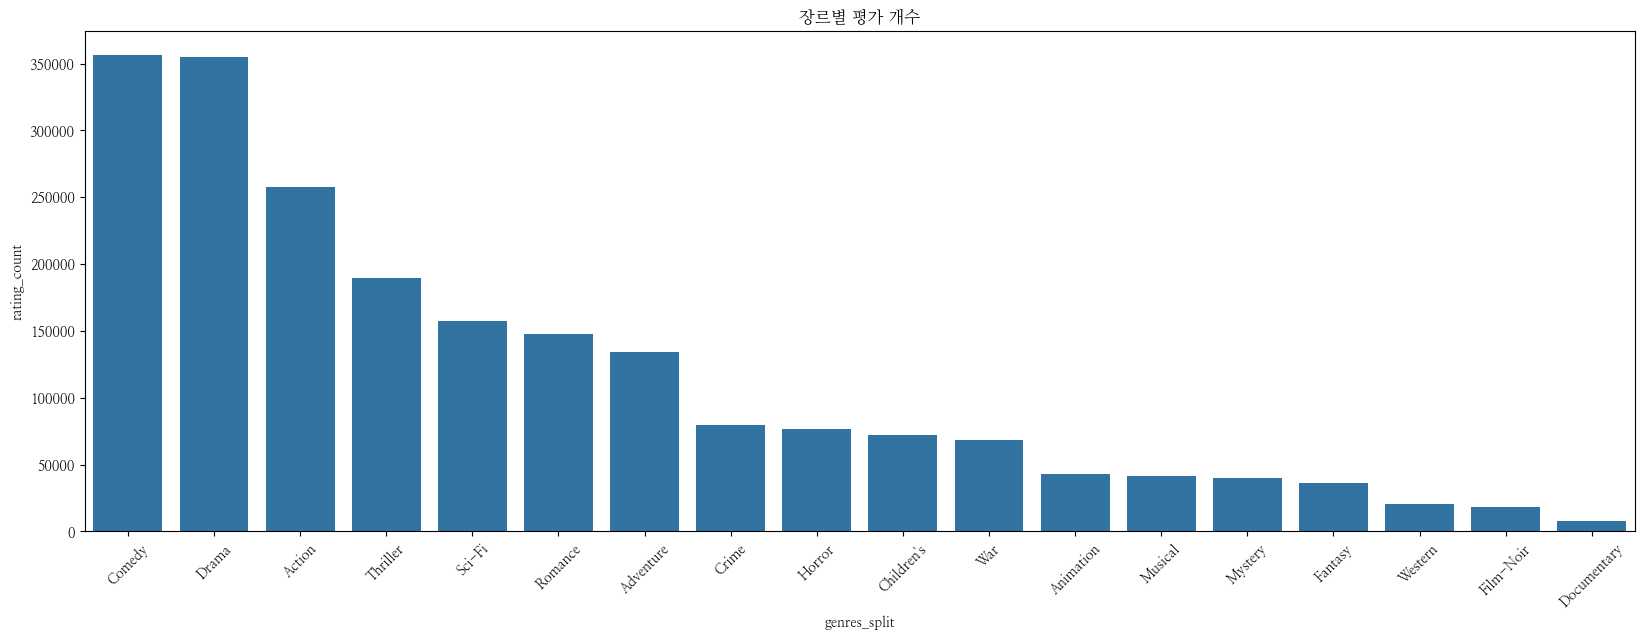

In [25]:
# seaborn 버전
rating_by_genre_df_sorted_by_count = rating_by_genre_df.sort_values('rating_count', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_count', data=rating_by_genre_df_sorted_by_count)
plt.title('장르별 평가 개수')
plt.xticks(rotation=45)
plt.show()

높은 평점을 가지고 있던 다큐멘터리의 평가 개수가 몇 개 없습니다. 어쩌면 편항되어 있는 데이터일 수도 있겠네요. 그리고 어쩌면, 다큐멘터리 영화를 본 사용자는 확실한 취향이 있을 수 있겠어요!


* 사용자 데이터(users)와 사용자가 가지고 있는 직업(occupation)을 매핑

In [26]:
# Occupation
occupation_map = {
    0:"other or not specified",
    1:"academic/educator",
    2:"artist",
    3:"clerical/admin",
    4:"college/grad student",
    5:"customer service",
    6:"doctor/health care",
    7:"executive/managerial",
    8:"farmer",
    9:"homemaker",
    10:"K-12 student",
    11:"lawyer",
    12:"programmer",
    13:"retired",
    14:"sales/marketing",
    15:"scientist",
    16:"self-employed",
    17:"technician/engineer",
    18:"tradesman/craftsman",
    19:"unemployed",
    20:"writer"
}

In [27]:
users['occupation_nm'] = users['occupation'].map(occupation_map)
users.head()

,user_id,gender,age,occupation,zip,occupation_nm
0,1,F,1,10,48067,K-12 student
1,2,M,56,16,70072,self-employed
2,3,M,25,15,55117,scientist
3,4,M,45,7,02460,executive/managerial
4,5,M,25,20,55455,writer


# 데이터 전처리

우리가 실습할 모델에서는 다음과 같은 피처(feature)들에 대해서 상호작용을 모델링하려고 합니다.

* 사용자 : 사용자 ID, 성별, 나이, 지역, 직업
* 영화 : 영화 ID, 장르, 시기
* 평점 : 사용자 ID, 영화 ID, 평점, 시기

즉 '어떤 사용자가 어떤 영화를 언제, 몇 점의 평가를 주었다'는 상호작용 데이터를 활용할 것입니다.

In [28]:
# 컬럼 정보 지정
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [29]:
# 데이터 불러오기 
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

In [30]:
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [31]:
# 영화 데이터 확인
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
# 평점 데이터 확인
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


##### 영화데이터 전처리

In [33]:
# 제목 뒤에 붙어 있는 연도를 정규표현식을 활용해 추출합니다. 
movies['movie_year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies.head()

,movie_id,title,genres,movie_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


제목에서 영화의 연도를 뽑아낸다.

연도에서 연도를 10으로 나눈 나머지를 빼면 년대이다.

예) 1995년 영화
* 1995 % 10 = 5
* 1995 - 5 = 1990 ➔ 90년대 영화

In [34]:
a = 1995 % 10
b = 1995 - a

print(a)
print(b)

5
1990


영화 데이터 전체에서 년대를 추출

In [35]:
# 90년대 영화, 2000년대 영화 등과 같은 년대 정보를 추출합니다. 
movies['movie_decade'] = movies['title'].str.extract(r'\((\d{4})\)')[0].astype(int).apply(lambda x: str(x - (x % 10)) + 's')
# title 컬럼에서 연도 정보를 빼고 제목만 따로 추출합니다.
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))

In [36]:
movies.head()

,movie_id,title,genres,movie_year,movie_decade
0,1,Toy Story,Animation|Children's|Comedy,1995,1990s
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1990s
2,3,Grumpier Old Men,Comedy|Romance,1995,1990s
3,4,Waiting to Exhale,Comedy|Drama,1995,1990s
4,5,Father of the Bride Part II,Comedy,1995,1990s


분리된 장르를 행(row)에 추가하였다면, 이번에는 컬럼(열)에 추가해 두겠습니다. 이렇게 구성하는 이유는 나중에 모델 input에 넣을 때 편리하기 때문

In [37]:
# | 기호를 기준으로 장르 데이터를 분리합니다. 
genres_split = movies['genres'].str.split('|')

In [38]:
max_genres = genres_split.apply(len).max() 

# 각 장르별로 새로운 컬럼을 생성합니다.
for i in range(max_genres):
    movies[f'genre{i + 1}'] = genres_split.apply(lambda x: x[i] if i < len(x) else None)

# 원래 있던 장르 컬럼은 날려줍니다.
movies.drop('genres', axis=1, inplace=True)

# None은 공백으로 채웁니다.
movies.fillna('', inplace=True)

In [39]:
print(movies.shape)
movies.head()

(3883, 10)


,movie_id,title,movie_year,movie_decade,genre1,genre2,genre3,genre4,genre5,genre6
0,1,Toy Story,1995,1990s,Animation,Children's,Comedy,,,
1,2,Jumanji,1995,1990s,Adventure,Children's,Fantasy,,,
2,3,Grumpier Old Men,1995,1990s,Comedy,Romance,,,,
3,4,Waiting to Exhale,1995,1990s,Comedy,Drama,,,,
4,5,Father of the Bride Part II,1995,1990s,Comedy,,,,,


* 모든 장르의 종류

In [40]:
set(movies['genre1'].unique().tolist() + movies['genre2'].unique().tolist() + movies['genre3'].unique().tolist())

{'',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

##### 평점 데이터 전처리

평점 데이터(ratings)도 조금 더 세분화하여 쪼갤 수 있습니다. 바로 timestmap를 이용하면 되는데요.

앞서 ratings에 있는 timestamp는 Unix timestamp라고 언급하였습니다. Unix timestamp란 1970년 1월 1일 00:00:00 UTC 이후 경과한 '초' 수를 말합니다. 따라서 '연-월-일' 로 변환이 필요합니다.

'년-월-일'로 변환하는 방법은 간단합니다. Unix timestamp는 워낙 많이 사용하기 때문에 이미 파이썬 내장 함수에도 기능이 존재기 때문이죠. datetime의 fromtimestamp 함수를 사용하면 바로 변환할 수 있습니다.

In [41]:
# 예
timestamp = 978300760 
dt_object = datetime.fromtimestamp(timestamp)

print(dt_object.strftime("%Y-%m-%d"))

2001-01-01


In [42]:
ratings['timestamp'] = ratings['timestamp'].apply(lambda x : datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,2001-01-01
1,1,661,3,2001-01-01
2,1,914,3,2001-01-01
3,1,3408,4,2001-01-01
4,1,2355,5,2001-01-07


In [43]:
# 변환된 '년-월-일' 데이터를 활용해서 년도, 월, 그리고 년대를 뽑아냄.
ratings['rating_year'] = ratings['timestamp'].apply(lambda x : x.split("-")[0]) 
ratings['rating_month'] = ratings['timestamp'].apply(lambda x : x.split("-")[1])
ratings['rating_decade'] = ratings['rating_year'].astype(int).apply(lambda x: str(x - (x % 10)) + 's')

In [44]:
ratings.head()

,user_id,movie_id,rating,timestamp,rating_year,rating_month,rating_decade
0,1,1193,5,2001-01-01,2001,01,2000s
1,1,661,3,2001-01-01,2001,01,2000s
2,1,914,3,2001-01-01,2001,01,2000s
3,1,3408,4,2001-01-01,2001,01,2000s
4,1,2355,5,2001-01-07,2001,01,2000s


이렇게 뽑아낸 데이터들은 임시로 저장을 해두겠습니다. 임시 저장은 필수는 아니지만, 편의를 위해 저장해두려고 합니다.

저장된 데이터들은 _prepro라는 이름을 붙여서 csv 형태로 저장해 두겠습니다.

In [45]:
# 임시 저장 
movies.to_csv(f"{data_path}/movies_prepro.csv", index=False)
ratings.to_csv(f"{data_path}/ratings_prepro.csv", index=False)
users.to_csv(f"{data_path}/users_prepro.csv", index=False)

In [49]:
!ls ./recommand/autoint/ml-1m

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


# 모델 입력 데이터 생성
* 명식적 데이터(Explicit data): 사용자가 직접적으로 선호도를 표현한 데이터(예: 평점, 구독, 댓글, 리뷰, 좋아요, 싫어요, 차단 등)
* 암묵적 데이터(Implicit data): 사용자가 간접적으로 선호도를 표현한 데이터(예: 클릭 여부, 검색 기록, 방문 페이지, 마우스 움직임, 구매 내역, 시청 시간대 등)

명시적 데이터, 예를 들어 평점 데이터라면 1~5점과 같은 분포로 데이터가 존재하게 되고 이는 이진 분류(binary classification) 문제라기 보다 회귀(regression) 문제나 다중 분류(multiclass classification) 문제라고 볼 수 있을 것입니다.

하지만 암묵적 데이터인 클릭 여부로 보면 어떨까요?

클릭 여부는 '클릭을 했다, 안했다'와 같이 0과 1로 분리할 수 있습니다. 이 때 클릭을 했다는 것은 '선호'한다라는 의미도 담고 있기에, 선호 정보를 모델링한다고도 볼 수 있습니다.

무엇이 정답인지는 따로 정해진 바가 없습니다. 데이터와 서비스 전략에 따라 정답은 달라집니다.

이번 프로젝트에서는 '선호했다'를 기준으로 살펴보려고 합니다.

그런데 여기서 문제가 하나 있습니다. 그럼 '선호했다'라는 정보는 무엇이고 '선호하지 않는다'라는 정보는 무엇일까요? 그리고 그런 데이터가 MovieLens에 있을까요? 이 문제를 풀어나가보려고 합니다.

### 1. 랜덤 샘플링 기반 방법
우리가 가지고 있는 데이터에서 '선호도'를 뽑아내기 위한 데이터로는 평점 데이터(ratings)가 있습니다. 사용자가 영화에 평점을 매긴 데이터이죠.

문제는 평점이 1부터 5점까지라서 '어떤 것을 선호한다'라고 말하기 어렵습니다. 그래서 여기서부터는 가설을 세우고 진행하는 것이 좋습니다.

우리는 먼저 랜덤 샘플링 기반 방법으로 '선호', '비선호'를 추출할 겁니다. 순서는 아래와 같습니다.

선호 데이터를 추출한다.

사용자가 3점 이상의 점수를 부여한 영화를 '선호'한다고 가정한다.

이 데이터는 label=1인 값이다.

비선호 데이터를 추출한다.

2-1. 사용자가 선호했던 영화 리스트를 추출한다

2-2. 전체 영화 중 사용자가 선호한다고 체크하지 않은 영화 리스트를 추출한다. 만약 전체 영화가 100개이고 사용자가 선호한다고 한 영화가 10개라면, 선호하지 않은 영화는 90개이다.

2-3. 영화 리스트 중 일부를 랜덤으로 샘플링한다. 이때 선호 영화 1개당 5개의 비선호 영화를 추출한다. 예를 들어 선호 영화가 10개라면 비선호 영화는 총 50개를 추출한다. 즉 비선호 영화 90개 중 50개를 추출하는 것이다.

2-4. 이 비선호 영화를 label=0으로 세팅한다.

이제 위와 같은 순서로 하나씩 체크하면서 진행합시다.

In [50]:
# 1. 3점 이상의 점수를 부여한 영화를 '선호'영화라고 가정하고, 이를 label=1로 생성합니다.
ratings = ratings[ratings['rating'] >= 3]
ratings['label'] = 1
ratings.drop('rating', axis=1, inplace=True)
print(ratings.shape)
ratings.head()

(836478, 7)


,user_id,movie_id,timestamp,rating_year,rating_month,rating_decade,label
0,1,1193,2001-01-01,2001,01,2000s,1
1,1,661,2001-01-01,2001,01,2000s,1
2,1,914,2001-01-01,2001,01,2000s,1
3,1,3408,2001-01-01,2001,01,2000s,1
4,1,2355,2001-01-07,2001,01,2000s,1


In [51]:
# 1. 사용자가 봤던(선호했던) 영화 리스트를 추출합니다. 사용자마다 평점이 3점 이상인 영화 리스트가 구성됩니다. 
user_seen_movies = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
user_seen_movies.head()

,user_id,movie_id
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,..."


In [54]:
import random

# 2. 먼저 고유 영화와 고유 사용자들을 가지고 옵니다. 
unique_movies = movies['movie_id'].unique()
unique_users = users['user_id'].unique()
negative_users = []
negative_movies = []
negative_labels = []

# 사용자별로 하나씩 진행합니다.
for user in unique_users:
    # 충분한 이력이 없는 사용자는 넘어갑니다. 충분한 이력이 없는 사용자 데이터는 훈련에 방해가 되고 overfitting 등이 될 수 있습니다.
    if len(user_seen_movies[user_seen_movies['user_id'] == user]) < 1:
        continue
    # 2-1. 해당 사용자가 선호하는 영화 리스트를 가지고 옵니다.
    user_seen_movie_list = user_seen_movies[user_seen_movies['user_id'] == user]['movie_id'].values[0]
    # 2-2. 전체 영화 중 사용자가 선호한 영화 정보를 제외합니다.
    user_non_seen_movie_list = list(set(unique_movies) - set(user_seen_movie_list))
    # 2-3. 선호 영화 1개당 비선호 영화 5개를 추출합니다. 
    sample_pop_size = len(user_seen_movie_list)*5
    # 만약 비선호 영화 샘플 개수가 전체 영화 개수보다 크면, 비선호 영화 샘플 개수는 전체 영화 개수에서 사용자가 선호한 영화의 개수를 뺀 값(해당 사용자 입장에선 샘플링 최대 값)으로 설정합니다.
    if len(unique_movies) - len(user_seen_movie_list) < len(user_seen_movie_list)*5 :
        sample_pop_size = len(unique_movies) - len(user_seen_movie_list)
    # 랜덤으로 추출합니다. 
    user_negative_movie_list = random.sample(user_non_seen_movie_list, sample_pop_size)
    
    # 해당 값들을 리스트에 저장합니다.
    negative_users += [user for _ in range(len(user_negative_movie_list))]
    negative_movies += user_negative_movie_list
    negative_labels += [0 for _ in range(len(user_negative_movie_list))]

이렇게 만들어진 리스트는 사용자가 '비선호'한다는 정보를 담고 있습니다. 따라서, label도 0입니다.

이제 이 데이터를 하나의 데이터프레임으로 만들고 사용자 선호 정보와 합쳐주면 0과 1이 조합된 훈련 데이터가 만들어 집니다.

In [55]:
print(len(negative_users))
print(len(negative_movies))
print(len(negative_labels))

4068124
4068124
4068124


In [56]:
negative_ratings_df = pd.DataFrame({'user_id' : negative_users, 'movie_id' : negative_movies, 'label':negative_labels})
print(negative_ratings_df.shape)
negative_ratings_df.head()

(4068124, 3)


,user_id,movie_id,label
0,1,2303,0
1,1,2660,0
2,1,1062,0
3,1,57,0
4,1,789,0


최종적으로 모델 훈련에 사용하는 데이터를 구성하기 위해서 필요한 컬럼만 추출해 활용합니다. 필요한 컬럼은 아래와 같습니다.

* 평점 : 사용자 ID, 영화 ID, 레이블(label)
* 영화 : 영화 ID, 년대, 년도, 장르1
* 사용자 : 사용자 ID, 성별, 나이, 지역, 직업

이 데이터를 모아 하나로 합쳐줍니다.

In [57]:
ratings_df = ratings[['user_id', 'movie_id', 'label']] 
ratings_df = pd.concat([ratings_df, negative_ratings_df], axis=0)
movies_df = movies[['movie_id', 'movie_decade', 'movie_year', 'genre1']]
movies_df.columns = ['movie_id', 'decade', 'movie_year', 'genre']
user_df = users[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [58]:
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, user_df, on='user_id')
merge_mlens_data.dropna(inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,label,decade,movie_year,genre,gender,age,occupation,zip
0,1,1193,1,1970s,1975,Drama,F,1,10,48067
1,1,661,1,1990s,1996,Animation,F,1,10,48067
2,1,914,1,1960s,1964,Musical,F,1,10,48067
3,1,3408,1,2000s,2000,Drama,F,1,10,48067
4,1,2355,1,1990s,1998,Animation,F,1,10,48067


In [59]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','decade', 'movie_year', 'genre', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,decade,movie_year,genre,gender,age,occupation,zip,label
0,1,1193,1970s,1975,Drama,F,1,10,48067,1
1,1,661,1990s,1996,Animation,F,1,10,48067,1
2,1,914,1960s,1964,Musical,F,1,10,48067,1
3,1,3408,2000s,2000,Drama,F,1,10,48067,1
4,1,2355,1990s,1998,Animation,F,1,10,48067,1


데이터를 하나로 합치면 위와 같은 형태의 데이터프레임이 구성됩니다. 이 데이터를 활용하여 모델을 훈련할 수 있습니다. 이 데이터를 movielens_rcmm_v1이라고 명명하고 csv 형식으로 저장해 두겠습니다.

In [60]:
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v1.csv', index=False)

### 2. 선호도로 나누기

위에서 진행한 '1. 랜덤 샘플링 기반 방법'은 그리 좋은 방법은 아닙니다. 왜냐하면 사용자 정보를 무작위로 샘플링을 해서 임의로 데이터를 생성했기 때문입니다. 가장 좋은 것은 원본 데이터를 활용하는 것이죠.

따라서 2번째 과정에서는 샘플링을 하지 않고 데이터를 선호도로 나누려고 합니다. 이후 모델을 훈련할 때도 이 데이터를 활용할 것입니다.

먼저 데이터 전처리를 하고 저장했던 데이터를 불러옵시다.

In [61]:
users_df = pd.read_csv(f'{data_path}/users_prepro.csv')
ratings_df = pd.read_csv(f'{data_path}/ratings_prepro.csv')
movies_df = pd.read_csv(f'{data_path}/movies_prepro.csv')

In [62]:
print(users_df.columns)
print(ratings_df.columns)
print(movies_df.columns)

Index(['user_id', 'gender', 'age', 'occupation', 'zip'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'timestamp', 'rating_year',
       'rating_month', 'rating_decade'],
      dtype='object')
Index(['movie_id', 'title', 'movie_year', 'movie_decade', 'genre1', 'genre2',
       'genre3', 'genre4', 'genre5', 'genre6'],
      dtype='object')


1번 과정에서는 평점이 3점 이상인 데이터를 label=1로 설정하고 label=0은 랜덤 샘플링으로 추출했는데요, 이번 과정에서는 다음과 같은 순서로 데이터 선호도를 구성합니다.

* 평점이 4점 이상인 데이터를 label=1, 나머지를 label=0
* 필요한 데이터만 추출하고 저장

In [63]:
# 1. 4점 이상인 데이터를 1로, 아닌 데이터를 0으로 설정합니다.  
ratings_df['label'] = ratings_df['rating'].apply(lambda x : x >=4).astype(int)

ratings_df = ratings_df[['user_id', 'movie_id', 'rating_year','rating_month', 'rating_decade', 'label']]
ratings_df.head()

,user_id,movie_id,rating_year,rating_month,rating_decade,label
0,1,1193,2001,1,2000s,1
1,1,661,2001,1,2000s,0
2,1,914,2001,1,2000s,0
3,1,3408,2001,1,2000s,1
4,1,2355,2001,1,2000s,1


In [64]:
# 2. 필요 데이터만 가지고 옵니다. 특히 장르는 3개만 가지고 와서 활용합니다.  
movies_df = movies_df[['movie_id', 'movie_decade', 'movie_year', 'genre1', 'genre2', 'genre3']]
users_df = users_df[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [65]:
# 필요한 데이터를 합쳐줍니다.   
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, users_df, on='user_id')
merge_mlens_data.fillna('no', inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,rating_year,rating_month,rating_decade,label,movie_decade,movie_year,genre1,genre2,genre3,gender,age,occupation,zip
0,1,1193,2001,1,2000s,1,1970s,1975,Drama,no,no,F,1,10,48067
1,1,661,2001,1,2000s,0,1990s,1996,Animation,Children's,Musical,F,1,10,48067
2,1,914,2001,1,2000s,0,1960s,1964,Musical,Romance,no,F,1,10,48067
3,1,3408,2001,1,2000s,1,2000s,2000,Drama,no,no,F,1,10,48067
4,1,2355,2001,1,2000s,1,1990s,1998,Animation,Children's,Comedy,F,1,10,48067


In [66]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [67]:
# 저장합니다.
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v2.csv', index=False)